# training Pipeline Research

In this notebook, we aim to find a good training pipeline for predicting stock future return, to determine a training pipline is good or not really depend on the metrix we concerned and what stock we care, by the research in stock_feature_research.ipynb, we have chosen 10 stock, and now we decide to use accuracy as our metrix, and we want to find a pipline which can yield high accuracy and low std for all stock:

for each config-pipeline, we compute the average/std accuracy for each stock, and plot it to a graph to see which perform better

NOTE: why we care about accuracy:<br>
in context of stock future return prediction, we care both risen and fallen, and since accuracy take into account both positive and negative label( for recall, precision, f1 they care about positive label) we think this metrix can most represent what we want to achieve.

### Set up notebook (not important)
change directory to root and import stuff

In [1]:
import os

folder_name = "researchs"
if folder_name in os.getcwd():
    os.chdir(os.path.abspath(os.pardir))
%pwd

'/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中'

# Dataset
we use DbDocsDataset to get our dataset, previously we store all our docs in db

In [2]:
from datasets.docs_dataset import DocsDataset
from datasets.stock_dataset import StockMeta

docs_dataset = DocsDataset()
stock_meta = StockMeta("./organized_data/stock_metadata.csv")
docs_dataset, stock_meta

DocsDataset: load cached documents_df


(DocumentsDataset(size=2362609), StockMeta(stock_count=2607))

# Demo of model training pipeline
Let use an example to show the model training pipeline we have constructed.

我們使用「台積電」這支股票以及 logistic regression，並且使用以下preprocess-pipeline-config：<br>
我們程式可以分成以下steps:
1. 設置好我們的參數，包括股票、模型、以及前處理流程
2. 將資料分成train和val
3. 將train和val資料進行前處理（注意：我們使用 train_dataset 來fit vectorizer，並且使用同樣的vectorizer來transform val_dataset）
4. 將前處理好的資料丟進模型中訓練

### introduce preprocess pipeline
我們使用 pipeline 概念將文章資料集轉換成向廖資料
* docs_filterer: 首先filter掉不相關的文章
*  docs_labeler: 然後將文章標記上label
* keywords_extractor: 再來從文章中抽取關鍵字
* vectorizer: 最後將關鍵字轉換成向量


In [3]:
from preprocess.preprocess_pipeline import PreprocessPipeline
from preprocess.docs_filterer import IDocsFilterer, StockNameFilterer, Word2VecSimilarFilterer
from preprocess.docs_labeler import IDocsLabeler, FutureReturnDocsLabeler
from preprocess.keyword_extractor import IKeywordExtractor, JiebaKeywordExtractor
from preprocess.vectorlizer import IVectorlizer, KeywordsTfIdfVectorlizer
from utils.data import random_split_train_val
from sklearn.linear_model import LogisticRegression
from sklearn_model_process.train_eval_model import train_eval_model, display_evaluation_result

Splitting dataset into training and validation sets with ratio 0.8...


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/36/xrq0hvyj4t1g49sh7nhx56c00000gn/T/jieba.cache


preprocess train dataset
[Word2VecSimilarFilterer] fitting the filterer
load word2vec model from cache
[Word2VecSimilarFilterer] Filter documents by does content/title/author contain the top most similar words to the stock name


Loading model cost 0.298 seconds.
Prefix dict has been built succesfully.
filtering documents: 100%|██████████| 1890087/1890087 [00:40<00:00, 46330.29it/s]


left with 87197 documents after filtering


[FutureReturnDocsLabeler] labeling documents by the s day future return percentage of the stock...


labeling documents: 100%|██████████| 1026/1026 [00:00<00:00, 3286.00it/s]


left with 8341 documents after labeling


[JiebaKeywordExtractor] extract keywords from documents using jieba


extracting keywords: 100%|██████████| 8341/8341 [00:00<00:00, 2483826.03it/s]


remove 0 docs because of empty keywords
left with 8341 docs


[KeywordsTfIdfVectorlizer] fitting 8341 docs
vectorizer fitted.
[KeywordsTfIdfVectorlizer] transforming 8341 docs to vectors






preprocess val dataset
[Word2VecSimilarFilterer] Filter documents by does content/title/author contain the top most similar words to the stock name


filtering documents: 100%|██████████| 94460/94460 [00:02<00:00, 40337.78it/s]


left with 4414 documents after filtering


[FutureReturnDocsLabeler] labeling documents by the s day future return percentage of the stock...


labeling documents: 100%|██████████| 1026/1026 [00:00<00:00, 16637.18it/s]


left with 440 documents after labeling


[JiebaKeywordExtractor] extract keywords from documents using jieba


extracting keywords: 100%|██████████| 440/440 [00:00<00:00, 2189197.82it/s]


remove 0 docs because of empty keywords
left with 440 docs


[KeywordsTfIdfVectorlizer] transforming 440 docs to vectors


fitting model...
model prediction...
calculating performance metrics...





result:
Training accuracy: 0.6653878431842705
Validation accuracy: 0.6

Training classification report:
              precision    recall  f1-score   support

      fallen       0.63      0.33      0.43      3223
       risen       0.67      0.88      0.76      5118

    accuracy                           0.67      8341
   macro avg       0.65      0.60      0.60      8341
weighted avg       0.66      0.67      0.63      8341


Validation classification report:
              precision    recall  f1-score   support

      fallen       0.50      0.26      0.34       176
       risen       0.63      0.83      0.71       264

    accuracy                           0.60       440
   macro avg       0.56      0.54      0.53       440
weighted avg       0.58      0.60      0.56       440



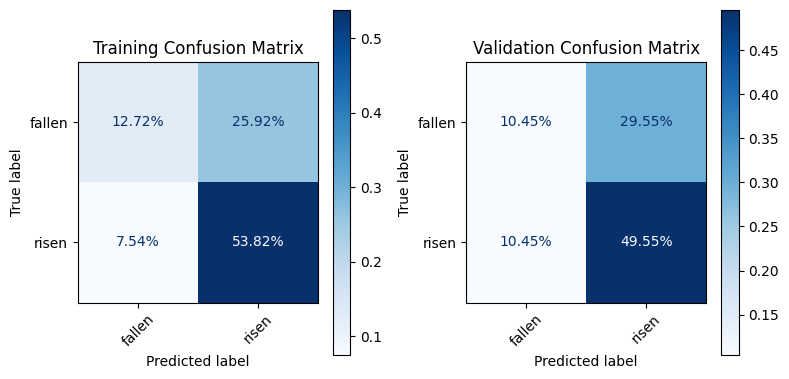

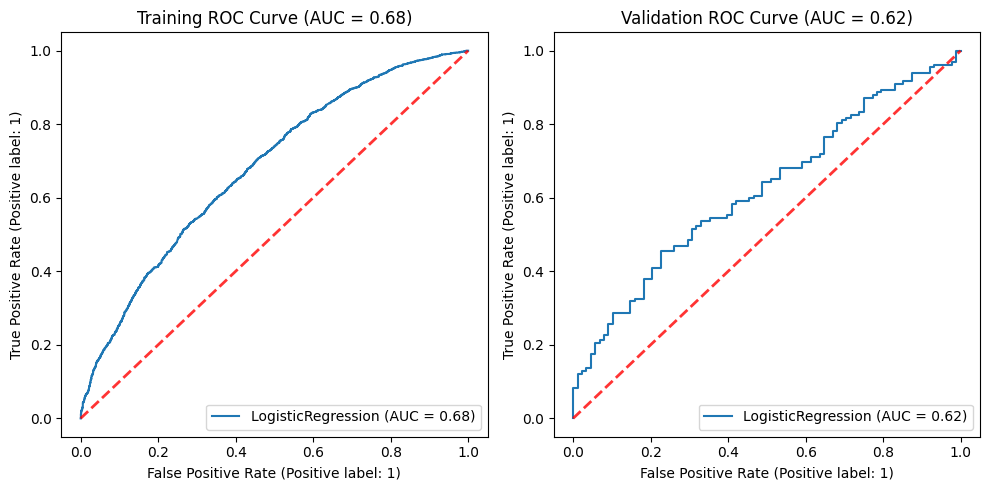

In [4]:
# set up config
stock = stock_meta.get_stock_by_name("台積電")
clf = LogisticRegression()
preprocess_pipeline = PreprocessPipeline(
    docs_filterer=Word2VecSimilarFilterer(topn=1, white_noise_ratio=0),
    docs_labeler=FutureReturnDocsLabeler(s=3, threshold=5),
    keywords_extractor=JiebaKeywordExtractor(),
    vectorizer=KeywordsTfIdfVectorlizer(count_features=1000, pca_components=100)
)

# split train and val
train_dataset, val_dataset = random_split_train_val(docs_dataset, split_ratio=0.8)
# preprocess dataset
print("preprocess train dataset")
train_dataset = preprocess_pipeline.preprocess(train_dataset, stock, do_fit=True, verbose=True)
print("\n\n\n\npreprocess val dataset")
val_dataset = preprocess_pipeline.preprocess(val_dataset, stock, do_fit=False, verbose=True)
# train and validate model
result = train_eval_model(clf, train_dataset, val_dataset, verbose=True)

# display result
print("\n\n\n\n\nresult:")
display_evaluation_result(result, clf, train_dataset, val_dataset)

## Search target & Domain
### Target
目標是要在以下股票中，模型能yield出高準確率和低標準差，目前我們使用‘台塑’作為研究對象<br>
['世界', '加權指數', '台積電', '統一', '台塑', '鴻海']

### Domain
我們定義我們的搜尋空間，我們將會在這個空間中找出最好的 training pipeline
我們使用以下模型：<br>
svc, knn, logistic regression, random forest, GussianNB, StackingClassifier(all before)<br>
搭配各種不同的前處理流程（在程式裡定義，這裡不一一列舉）：<br>

## Define search space
我們定義我們的搜尋空間，我們將會在這個空間中找出最好的模型和hyper parameters

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Support Vector Classifier
svc = make_pipeline(StandardScaler(), SVC(probability=True))

# K-Nearest Neighbors Classifier
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Logistic Regression Classifier
lr = make_pipeline(StandardScaler(), LogisticRegression())

# Random Forest Classifier
rf = RandomForestClassifier()

# Gaussian Naive Bayes Classifier
gnb = GaussianNB()

# Stacking Classifier
estimators = [('svc', svc), ('knn', knn), ('lr', lr), ('rf', rf), ('gnb', gnb)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=SVC(probability=True))


# stock names
stock_names = ['世界', '加權指數', '台積電', '統一', '台塑', '鴻海']
stock_name = '台塑'
# search space
models = [svc, knn, lr, rf, gnb, stacking_clf]
word2vec_similar__topns = [3]
future_return_docs_labeler__s = [1, 3, 10]
future_return_docs_labeler__thresholds = [1, 5, 10]
keywords_tfidf_vectorlizer__count_features = [1000]
keywords_tfidf_vectorlizer__pca_components = [100]

## Search
對於每一種組合，我們計算此組合對於全部股票的平均準確率和標準差，我們同時還使用5 fold，來最低母體和sample的差距

In [14]:
from sklearn.model_selection import ParameterGrid, KFold
import numpy as np
from pprint import pprint
from tqdm import tqdm

# Define search space
param_grid = {
    'model': models,
    'word2vec_similar_topn': word2vec_similar__topns,
    'future_return_docs_labeler_s': future_return_docs_labeler__s,
    'future_return_docs_labeler__thresholds': future_return_docs_labeler__thresholds,
    'keywords_tfidf_vectorlizer_count_features': keywords_tfidf_vectorlizer__count_features,
    'keywords_tfidf_vectorlizer_pca_components': keywords_tfidf_vectorlizer__pca_components
}

# Initialize grid search
grid = ParameterGrid(param_grid)
config_results = []

# Define the number of folds for cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits)



# Grid search loop
for config in grid:
    accuracies = []

    print(f"config:")
    pprint(config)
    pbar = tqdm(range(n_splits))
    for fold in pbar:
        pbar.set_description(f"stock: {stock_name}, fold: {fold}")
        stock = stock_meta.get_stock_by_name(stock_name)
        
        # split train and val
        train_dataset, val_dataset = random_split_train_val(docs_dataset, split_ratio=0.7, verbose=False)

        # Update pipeline with config
        preprocess_pipeline = PreprocessPipeline(
            docs_filterer=Word2VecSimilarFilterer(topn=config['word2vec_similar_topn'], white_noise_ratio=0),
            docs_labeler=FutureReturnDocsLabeler(s=config['future_return_docs_labeler_s'], threshold=config['future_return_docs_labeler__thresholds']),
            keywords_extractor=JiebaKeywordExtractor(),
            vectorizer=KeywordsTfIdfVectorlizer(count_features=config['keywords_tfidf_vectorlizer_count_features'],
                                               pca_components=config['keywords_tfidf_vectorlizer_pca_components'])
        )

        # Preprocess datasets
        processed_train_dataset = preprocess_pipeline.preprocess(train_dataset, stock, do_fit=True, verbose=False)
        # check label have both 1 and 0
        if len(np.unique(processed_train_dataset.labels)) != 2:
            continue
        processed_val_dataset = preprocess_pipeline.preprocess(val_dataset, stock, do_fit=False, verbose=False)

        # Train and validate model
        clf = config['model']
        result = train_eval_model(clf, processed_train_dataset, processed_val_dataset, verbose=False)

        # record validate accuracy
        accuracies.append(result.val_accuracy)

    # Compute average and standard deviation
    avg_accuracy = np.mean(accuracies)

    # Record config and results
    config_results.append({
        'config': config,
        'accuracy_avg': avg_accuracy,
        'result': result
    })

    # Display config results
    print(f"Average Accuracy: {avg_accuracy}")



config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:17<00:00, 77.95s/it]


Average Accuracy: 0.5864978902953587
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:18<00:00, 78.88s/it]


Average Accuracy: 0.5179282868525896
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [02:02<00:00, 122.37s/it]


Average Accuracy: 0.6123348017621145
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': RandomForestClassifier(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:18<00:00, 78.54s/it]


Average Accuracy: 0.5421686746987951
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': GaussianNB(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:11<00:00, 71.31s/it]


Average Accuracy: 0.5756302521008403
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': StackingClassifier(estimators=[('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True))])),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('lr',
                                Pipeline(steps=[('standardscaler',
                         

stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:45<00:00, 105.75s/it]


Average Accuracy: 0.4864864864864865
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [02:23<00:00, 143.79s/it]


Average Accuracy: 0.6005221932114883
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:15<00:00, 75.36s/it]


Average Accuracy: 0.5597014925373134
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:15<00:00, 75.23s/it]


Average Accuracy: 0.6034063260340633
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': RandomForestClassifier(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:20<00:00, 80.36s/it]


Average Accuracy: 0.5652173913043478
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': GaussianNB(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:52<00:00, 112.46s/it]


Average Accuracy: 0.5798525798525799
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 3,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': StackingClassifier(estimators=[('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True))])),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('lr',
                                Pipeline(steps=[('standardscaler',
                         

stock: 台塑, fold: 0: 100%|██████████| 1/1 [02:48<00:00, 168.88s/it]


Average Accuracy: 0.5166666666666667
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:55<00:00, 115.56s/it]


Average Accuracy: 0.6334586466165414
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:20<00:00, 80.14s/it]


Average Accuracy: 0.5428571428571428
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [02:00<00:00, 120.17s/it]


Average Accuracy: 0.567219152854512
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': RandomForestClassifier(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:24<00:00, 84.44s/it]


Average Accuracy: 0.5354969574036511
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': GaussianNB(),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:19<00:00, 79.12s/it]


Average Accuracy: 0.5775401069518716
config:
{'future_return_docs_labeler__thresholds': 1,
 'future_return_docs_labeler_s': 10,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': StackingClassifier(estimators=[('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True))])),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('lr',
                                Pipeline(steps=[('standardscaler',
                        

stock: 台塑, fold: 0: 100%|██████████| 1/1 [03:54<00:00, 234.80s/it]


Average Accuracy: 0.49619771863117873
config:
{'future_return_docs_labeler__thresholds': 5,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0:   0%|          | 0/1 [00:00<?, ?it/s]/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

Average Accuracy: 0.8181818181818182
config:
{'future_return_docs_labeler__thresholds': 5,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0: 100%|██████████| 1/1 [01:07<00:00, 67.70s/it]


Average Accuracy: 0.7142857142857143
config:
{'future_return_docs_labeler__thresholds': 5,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]),
 'word2vec_similar_topn': 3}


stock: 台塑, fold: 0:   0%|          | 0/1 [01:08<?, ?it/s]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Search 結果
我們找到能給出最高準確率的模型與設定，同時，我們也發現調整 s（futrue return days）太高會造成文章引響力低但太低的話雜訊又會太多;另一方面 threshhold影響也很大，如果調太低會造成資料不準確，但太高的話如意會沒有文章資料。

以下展示我們最好的模型結果，我們展示各種模型最高準確率，我們發現使用svc 在我們研究中拿到最高81%的accuracy，有趣的是，最複雜的stacking模型反而表現非常不好

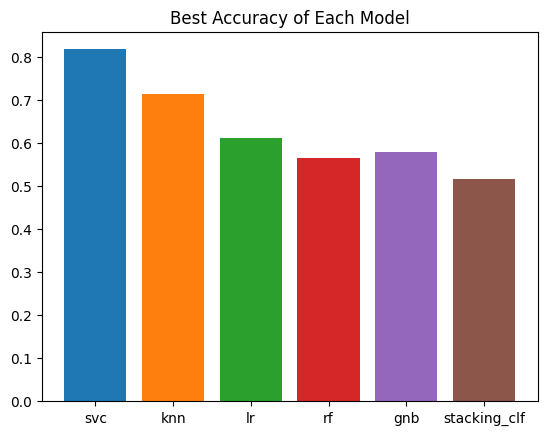

,model,accuracy
0,svc,0.818182
1,knn,0.714286
2,lr,0.612335
3,rf,0.565217
4,gnb,0.579853
5,stacking_clf,0.516667


In [81]:
import matplotlib.pyplot as plt
# use config_results to get a dictionary which map model name to its best config and best accuracy
model_best_config = {}
for config_result in config_results:
    config = config_result['config']
    model_name = str(config['model'])
    if model_name not in model_best_config:
        model_best_config[model_name] = {
            'config': config,
            'result': config_result
        }
    else:
        if config_result['accuracy_avg'] > model_best_config[model_name]['result']['accuracy_avg']:
            model_best_config[model_name] = {
                'config': config,
                'result': config_result
            }
name_model_to_best_config = {}
for model, name in zip(model_best_config.keys(), ['svc', 'knn', 'lr', 'rf', 'gnb', 'stacking_clf']):
    name_model_to_best_config[name] = model_best_config[model]

# plot each model's best accuracy
for model_name, config in name_model_to_best_config.items():
    model_accuracy = config['result']['accuracy_avg']
    plt.bar(model_name, model_accuracy)
plt.title('Best Accuracy of Each Model')
plt.show()

# display model best accuracy using dataframe
import pandas as pd

model_best_accuracies = []
for model_name, config in name_model_to_best_config.items():
    model_accuracy = config['result']['accuracy_avg']
    model_best_accuracies.append({
        'model': model_name,
        'accuracy': model_accuracy
    })
model_best_accuracies_df = pd.DataFrame(model_best_accuracies)
display(model_best_accuracies_df)
    

最後我們呈現我們最好的模型的metrix，並且是用在其他股票看看效果

In [98]:
name_model_to_best_config['svc']['config']

{'future_return_docs_labeler__thresholds': 5,
 'future_return_docs_labeler_s': 1,
 'keywords_tfidf_vectorlizer_count_features': 1000,
 'keywords_tfidf_vectorlizer_pca_components': 100,
 'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(probability=True))]),
 'word2vec_similar_topn': 3}

Splitting dataset into training and validation sets with ratio 0.7...


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/36/xrq0hvyj4t1g49sh7nhx56c00000gn/T/jieba.cache


preprocess train dataset
[Word2VecSimilarFilterer] fitting the filterer
load word2vec model from cache
[Word2VecSimilarFilterer] Filter documents by does content/title/author contain the top most similar words to the stock name


Loading model cost 0.327 seconds.
Prefix dict has been built succesfully.
filtering documents: 100%|██████████| 1653826/1653826 [00:37<00:00, 43870.11it/s]


left with 80444 documents after filtering


[FutureReturnDocsLabeler] labeling documents by the s day future return percentage of the stock...


labeling documents: 100%|██████████| 1026/1026 [00:00<00:00, 23439.65it/s]


left with 810 documents after labeling


[JiebaKeywordExtractor] extract keywords from documents using jieba


extracting keywords: 100%|██████████| 810/810 [00:00<00:00, 1351924.49it/s]

remove 0 docs because of empty keywords
left with 810 docs


[KeywordsTfIdfVectorlizer] fitting 810 docs


vectorizer fitted.
[KeywordsTfIdfVectorlizer] transforming 810 docs to vectors






preprocess val dataset
[Word2VecSimilarFilterer] Filter documents by does content/title/author contain the top most similar words to the stock name


filtering documents: 100%|██████████| 212494/212494 [00:05<00:00, 39515.39it/s]


left with 10494 documents after filtering


[FutureReturnDocsLabeler] labeling documents by the s day future return percentage of the stock...


labeling documents: 100%|██████████| 1026/1026 [00:00<00:00, 49690.04it/s]


left with 80 documents after labeling


[JiebaKeywordExtractor] extract keywords from documents using jieba


extracting keywords: 100%|██████████| 80/80 [00:00<00:00, 1198372.57it/s]


remove 0 docs because of empty keywords
left with 80 docs


[KeywordsTfIdfVectorlizer] transforming 80 docs to vectors


fitting model...
model prediction...
calculating performance metrics...





result:
Training accuracy: 0.9703703703703703
Validation accuracy: 0.925

Training classification report:
              precision    recall  f1-score   support

      fallen       0.99      0.80      0.88       115
       risen       0.97      1.00      0.98       695

    accuracy                           0.97       810
   macro avg       0.98      0.90      0.93       810
weighted avg       0.97      0.97      0.97       810


Validation classification report:
              precision    recall  f1-score   support

      fallen       1.00      0.25      0.40         8
       risen       0.92      1.00      0.96        72

    accuracy                           0.93        80
   macro avg       0.96      0.62      0.68        80
weighted avg       0.93      0.93      0.90        80



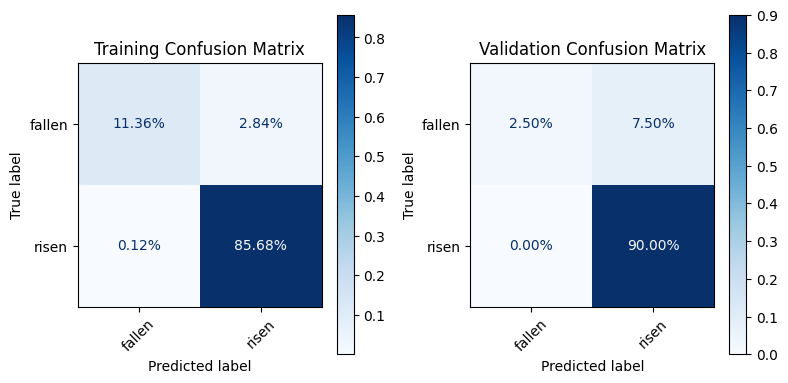

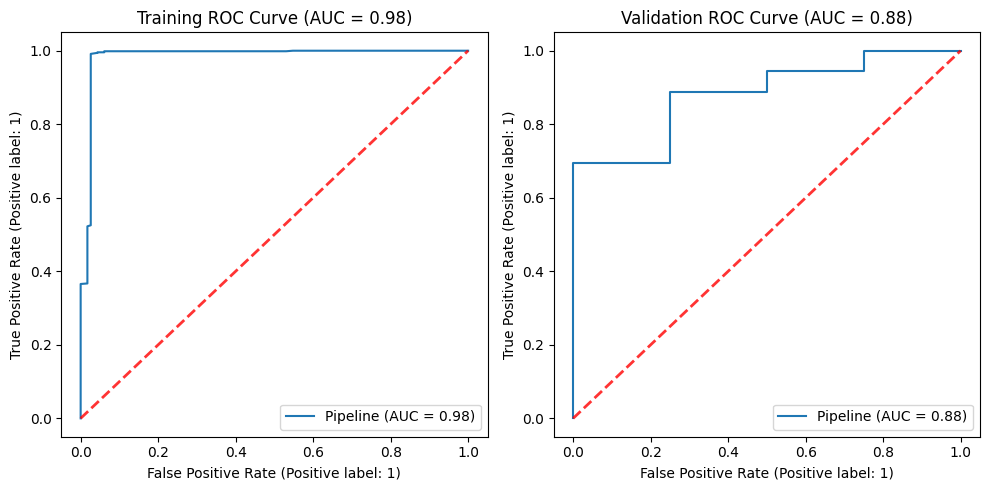

In [6]:
# set up config
stock = stock_meta.get_stock_by_name('台積電')
clf = make_pipeline(StandardScaler(), SVC(probability=True))
preprocess_pipeline = PreprocessPipeline(
    docs_filterer=Word2VecSimilarFilterer(topn=3, white_noise_ratio=0),
    docs_labeler=FutureReturnDocsLabeler(s=1, threshold=5),
    keywords_extractor=JiebaKeywordExtractor(),
    vectorizer=KeywordsTfIdfVectorlizer(count_features=1000, pca_components=100)
)

# split train and val
train_dataset, val_dataset = random_split_train_val(docs_dataset, split_ratio=0.7)
# preprocess dataset
print("preprocess train dataset")
train_dataset = preprocess_pipeline.preprocess(train_dataset, stock, do_fit=True, verbose=True)
print("\n\n\n\npreprocess val dataset")
val_dataset = preprocess_pipeline.preprocess(val_dataset, stock, do_fit=False, verbose=True)
# train and validate model
result = train_eval_model(clf, train_dataset, val_dataset, verbose=True)

# display result
print("\n\n\n\n\nresult:")
display_evaluation_result(result, clf, train_dataset, val_dataset)

由此發現，確實accuracy高，但主要是因為s小 threshold大時我們的資料集會很小，且看起來大部分文章多會特別注重漲，且資料有可能不平衡。